In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns


# Model Design

In [2]:
def design_model(features):
  model = Sequential(name = "Forest_Cover_Classification")

  #add an input layer
  model.add(InputLayer(input_shape=(features.shape[1],)))

  # hidden layers 
  model.add(Dense(128, activation = 'relu'))
  #adding an output layer to our forest cover classification model

  model.add(Dense(8, activation='softmax')) # add an output layer

  #add optimizer Adam
  opt = Adam(learning_rate = 0.001)
  model.compile(loss='sparse_categorical_crossentropy',  metrics=['accuracy'], optimizer=opt)
    
  return model

# load data

In [3]:
dataset = pd.read_csv('cover_data.csv') #load land cover data into dataframe
dataset.info() #print columns and their respective types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
Elevation                             581012 non-null int64
Aspect                                581012 non-null int64
Slope                                 581012 non-null int64
Horizontal_Distance_To_Hydrology      581012 non-null int64
Vertical_Distance_To_Hydrology        581012 non-null int64
Horizontal_Distance_To_Roadways       581012 non-null int64
Hillshade_9am                         581012 non-null int64
Hillshade_Noon                        581012 non-null int64
Hillshade_3pm                         581012 non-null int64
Horizontal_Distance_To_Fire_Points    581012 non-null int64
Wilderness_Area1                      581012 non-null int64
Wilderness_Area2                      581012 non-null int64
Wilderness_Area3                      581012 non-null int64
Wilderness_Area4                      581012 non-null int64
Soil_Type1                            581012 non-

In [4]:
#print the class distribution
Counter(dataset["class"])

Counter({5: 9493, 2: 283301, 1: 211840, 7: 20510, 3: 35754, 6: 17367, 4: 2747})

# Data Preprocessing

In [5]:
dataset = dataset.values

#extract the features from the dataset
features = dataset[:, :-1]

#extract the label column from the dataset
labels = dataset[:, -1]

 # Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

#Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train and compile the model

Model: "Forest_Cover_Classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               7040      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total params: 8,072
Trainable params: 8,072
Non-trainable params: 0
_________________________________________________________________
None
[INFO] training model...
Epoch 1/100
364/364 [==============================] - 1s 3ms/step - loss: 0.9661 - accuracy: 0.6405 - val_loss: 0.6220 - val_accuracy: 0.7402
Epoch 2/100
364/364 [==============================] - 1s 2ms/step - loss: 0.6060 - accuracy: 0.7442 - val_loss: 0.5772 - val_accuracy: 0.7566
Epoch 3/100
364/364 [==============================] - 1s 2ms/step - loss: 0.5660 - accuracy: 0.7614 - val_loss: 0.5526 - val_accuracy: 0.7691
Epoch 4/100
364/364 [===================

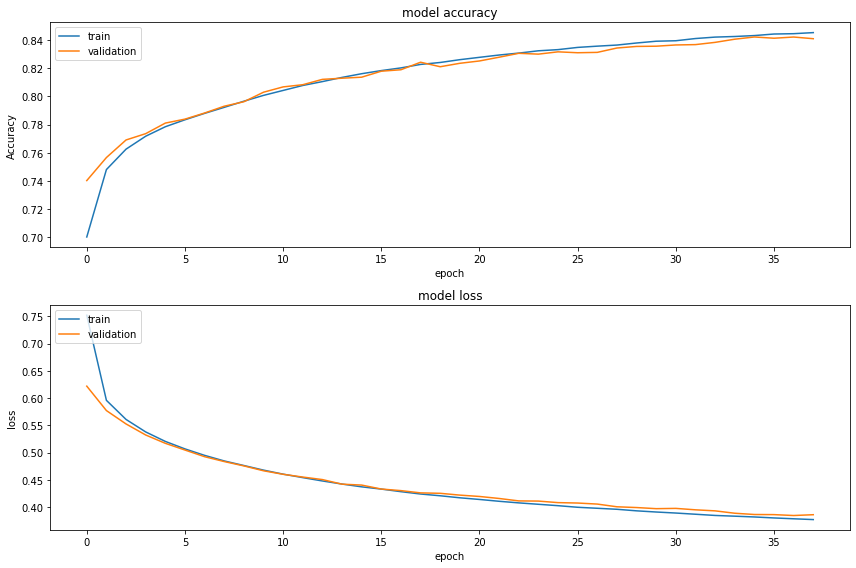

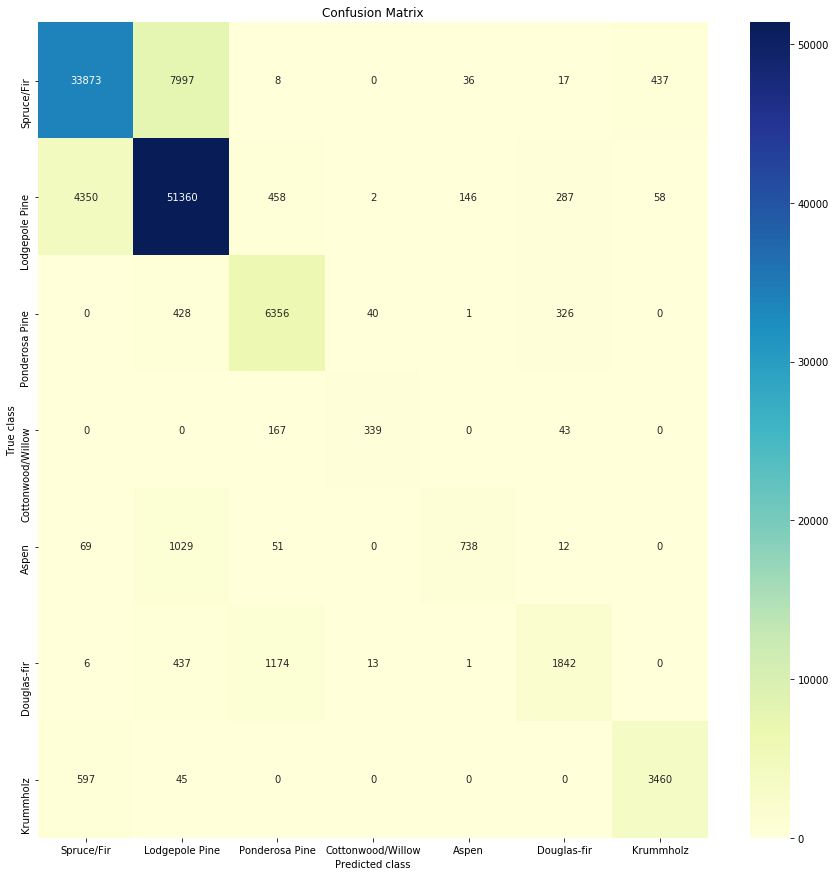

In [6]:
#invoke the function for our model design
model = design_model(X_train)
print(model.summary()) #print model summary information

print("[INFO] training model...")
#train and evaluate the model
num_epochs = 100
BATCH_SIZE = 1024
# epochs and early stopping
stop = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3) 

history = model.fit(
    X_train, y_train, 
    epochs=num_epochs, 
    batch_size=BATCH_SIZE, 
    verbose=1, 
    validation_split=0.2, callbacks=[stop])

loss, acc = model.evaluate(X_test, y_test, verbose=0) #accuracy of model

print('Accuracy: ', acc)

#get additional statistics
class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']

y_estimate = model.predict(X_test, verbose=0)

y_estimate = np.argmax(y_estimate, axis=1)

print(classification_report(y_test, y_estimate, target_names=class_names))


# model performance plotting
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
 
# Plot loss and val_loss over each epoch
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')
 
# used to keep plots from overlapping each other  
fig.tight_layout()
fig.savefig('plots.png')

#Confusion matrix plot

cm = confusion_matrix(y_test, y_estimate)

fig, ax = plt.subplots(figsize=(15, 15))
heatmap = sns.heatmap(cm, fmt='g', cmap='YlGnBu', annot=True, ax=ax)
ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
 # Save the heatmap to file
heatmapfig = heatmap.get_figure()
heatmapfig.savefig('confusion_matrix.png')